<a href="https://colab.research.google.com/github/guido-niku/Food-101/blob/master/Food101-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Food 101 challenge**
(For consideration at Fellowship.AI)
Challenge Problem

The question is stated as follows:

"Food-101 is a challenging vision problem, but everyone can relate to it.  Recent SoTA is ~80% top-1, 90% top-5.  These approaches rely on lots of TTA, large networks and  even novel architectures.

Train a decent model >85% accuracy for top-1 for the test set, using a ResNet50 or smaller network with a reasonable set of augmentations.  "


### **Task: Classification**

Classification of 101 different classes of food, using a dataset containing 1000 labeled images per class available for supervised training.


### **Goal : Attain >85% accuracy for top-1 for the test set.**

Top-1 accuracy is the accuracy as commonly understood. For our model, it is decided by the class with the highest probability determined by the network.


### **Constraints**

- using a ResNet50 or smaller network 
- with a reasonable set of augmentations.

## **My thoughts** 
My immediate considerations were:
- Using Transfer learning
- Use traditional data augmentation techniques
- Use Resnet50 or a smaller network in terms of number of parameters (ie：mobilenet ?)
- Pay attention to colab runtime limitations

Some footsteps online:
- https://www.kaggle.com/theimgclist/multiclass-food-classification-using-tensorflow/data
- http://blog.stratospark.com/deep-learning-applied-food-classification-deep-learning-keras.htm


# The data


Downloading and extracting the data

In [0]:
!wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
! tar -xvf food-101.tar.gz


Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

After downloading and extracting, the files are seperated in respectives folders for use the default imagedatagenerator in the keras library.
- food-101 
- food-101-test
both folders have the same structure(one subfolder per class). I found this easier to manage, since the ImageDatagenerator ( code below ) needs a suitable folder arrangement

In [0]:
import glob
import os


for names in glob.glob("/content/food-101/images/*"):
  os.makedirs(names.replace("food-101","food-101-test"))

with open('/content/food-101/meta/test.txt', 'r') as f:
    testlist = f.readlines() #read the file names of test set
with open('/content/food-101/meta/train.txt', 'r') as f:
    trainlist = f.readlines() #train set names

import shutil
for item in testlist:
  path = "/content/food-101/images/"+ item[:-1]+".jpg" #get the names of each pictures, append the extension
  target = path.replace("food-101","food-101-test") #move to a similar but seperated folder
  shutil.move(path, target)

number_of_train_files = len(glob.glob("/content/food-101/images/*/*"))
number_of_test_files = len(glob.glob("/content/food-101-test/images/*/*"))
print("Number of training images:",number_of_train_files )
print("Number of testing images:",number_of_test_files )

Number of training images: 75750
Number of testing images: 25250


# Data Check

Using TensorFlow backend.


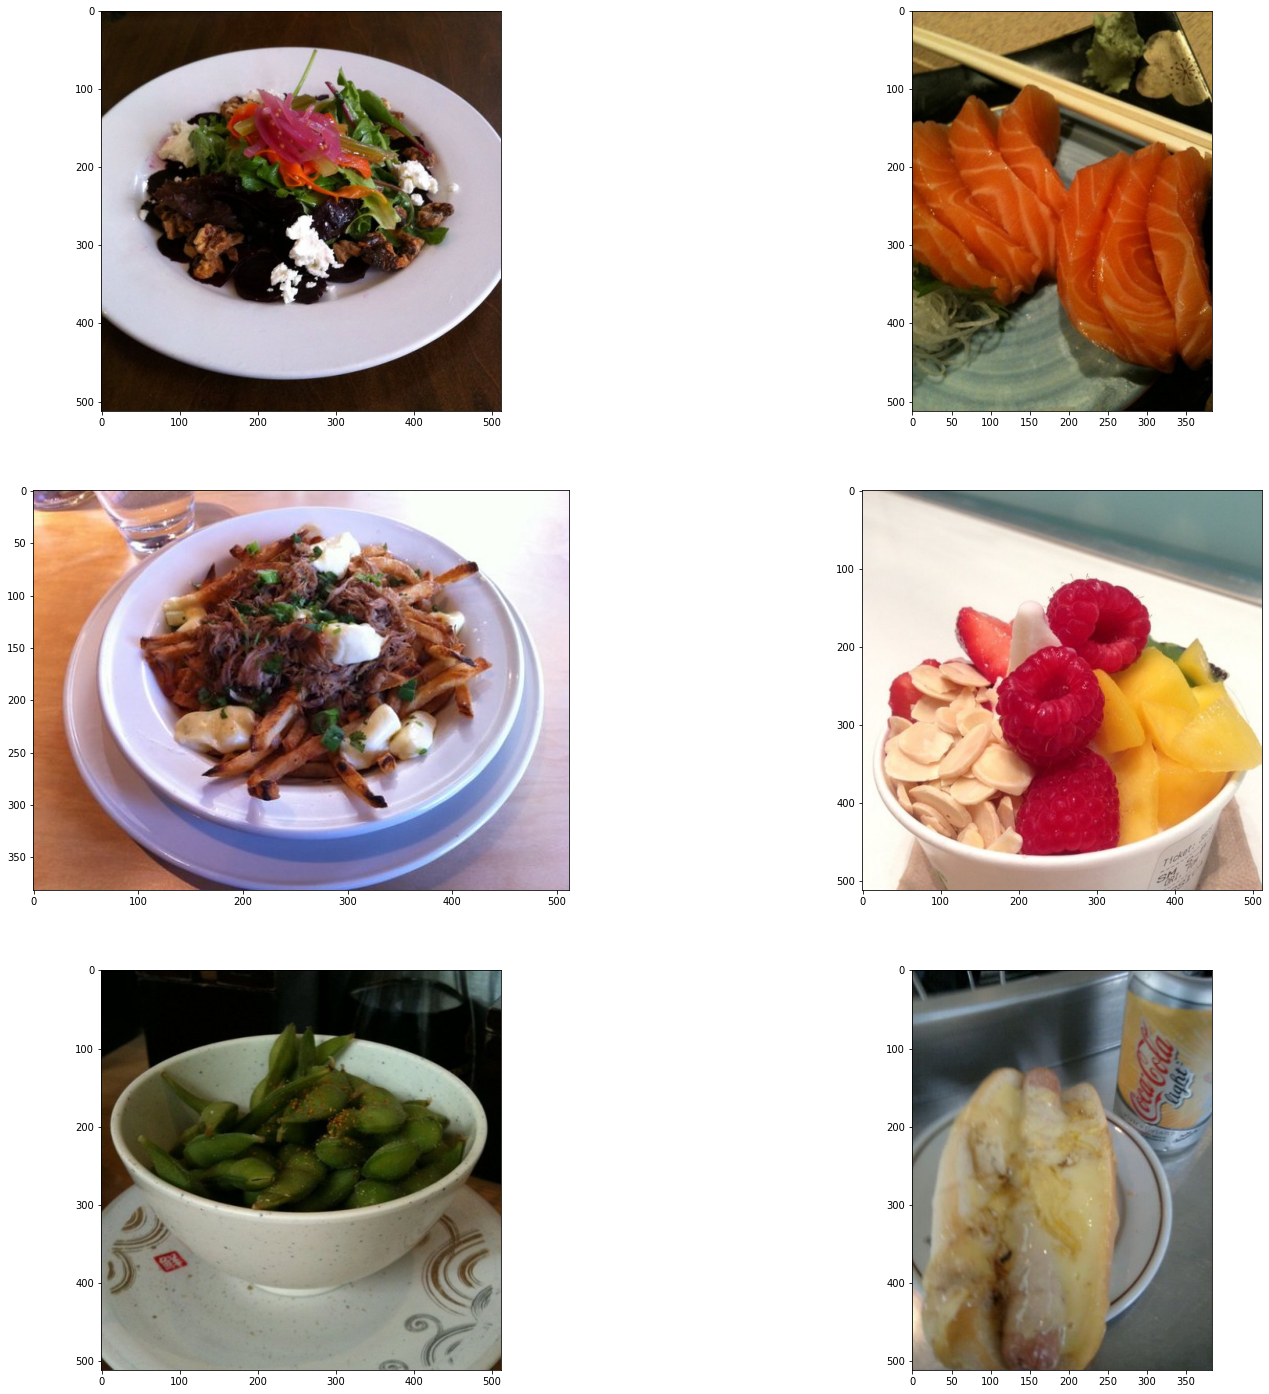

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from keras.preprocessing import image



f, axarr = plt.subplots(3,2,figsize=(25,25))

axarr[0,0].imshow(image.load_img(glob.glob("/content/food-101/images/*/*")[randint(0,number_of_train_files)]))
axarr[0,1].imshow(image.load_img(glob.glob("/content/food-101/images/*/*")[randint(0,number_of_train_files)]))
axarr[1,0].imshow(image.load_img(glob.glob("/content/food-101/images/*/*")[randint(0,number_of_train_files)]))
axarr[1,1].imshow(image.load_img(glob.glob("/content/food-101/images/*/*")[randint(0,number_of_train_files)]))
axarr[2,0].imshow(image.load_img(glob.glob("/content/food-101/images/*/*")[randint(0,number_of_train_files)]))
axarr[2,1].imshow(image.load_img(glob.glob("/content/food-101/images/*/*")[randint(0,number_of_train_files)]))



At a few glances, the dataset demonstrate a large variety of food items. The label is related to the dish captured. We can take note that not the entirety of the image content is related to the label. 

# Ability to save for later
We rely on google drive to save the progress of training.

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Library and models import


In [0]:
import keras
import numpy as np

from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

from keras.preprocessing import image
from keras.layers import Dense, Conv2D, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.models import Model

size = 128 #input image size, 128x128
BATCH_SIZE = 32


Using TensorFlow backend.


# ImageDataGenerator
Using flow_from_directory to feed the images in batches of 32 during training.
I  set up two generator, one with image augmentation, one without, to be used alternatively.
We also create another "non augmenting" data generator for convenience and trials.

The choice of the Imagedatagenerator is justified by:
- the size of the dataset ( cannot fit in the memory ）
- the augmentation facilities

Only the training data is augmented, not the testing data.

The various transformation implemented are:

- rotation and shear: which may help generalize over pictures taken at different angles.
 
- zoom: due to the varying proportions of details (ie: a plate of fries, where the fries occupies only 30% of the picture) of the pictures that actually represent their associated class

- shift: a hint to apply random cropping in http://blog.stratospark.com/deep-learning-applied-food-classification-deep-learning-keras.htm, we attempt to simulate it by simply shifting the frame of the pictures ( the resulting picture has empty spaces possibly filled by an uniform colors )

- brightness range : to accomodate to the varying lighting conditions of the photos



In [0]:
augment = True

no_augment_data_generator = image.ImageDataGenerator(                                          
    preprocessing_function = keras.applications.mobilenet_v2.preprocess_input,
    )

data_generator = image.ImageDataGenerator(                                          
    rotation_range=10,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.3,1.0],
    preprocessing_function = keras.applications.mobilenet_v2.preprocess_input,
    )


train_generator = data_generator.flow_from_directory(
        '/content/food-101/images',
        target_size=(size,size),
        batch_size=BATCH_SIZE,
        class_mode='categorical',        
        seed = 1,
        )

no_augment_train_generator = no_augment_data_generator.flow_from_directory(
        '/content/food-101/images',
        target_size=(size,size),
        batch_size=BATCH_SIZE,
        class_mode='categorical',        
        seed = 1,
        )

validation_generator = no_augment_data_generator.flow_from_directory(
        '/content/food-101-test/images',
        target_size=(size,size),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        seed = 1,
        )

Found 75750 images belonging to 101 classes.
Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


# Model import 
We import the pretrained models.
Using summary(), we verify the size of each model and their number of parameters.

- The resnet50 model has 25,636,712 parameters, so we are aiming for anything smaller = lower number of parameters.
- MobileNetv2 is another good candidate with about 3.5 million parameters ( faster to train ).
- VGG is out of the question.
- Based on number of parameters, other possible candidates ( https://keras.io/applications/#xception ) : DenseNet121, DenseNet169, DenseNet201, NASNetMobile, InceptionV3. 
- The choice for mobileNetv2 is also motivated by the limited training environement and the deadline :)

We use the 128x128 input size, which can still take advantage of the pre-trained weights from imagenet. Another motivation of to obtain a lighter architecture for computations.

In [0]:


mobile_model = MobileNetV2(input_shape=(size,size,3))
# resnet_model = ResNet50(input_shape=(size,size,3))
# vgg19_model = VGG19(input_shape=(size,size,3))
# vgg16_model = VGG16(input_shape=(size,size,3))

# vgg19_model.summary()
# vgg16_model.summary()
# resnet_model.summary()
mobile_model.summary()


14540800/14536120 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
______________

The original model is meant for imagenet, so we repurpose it for our problem which has 101 classes. We also freeze the layers from the original model. As we aim to a high accuracy, we also implement early stopping for the learning rate to be progressively reduced when the loss stagnates without improvements over a few epochs.

In [0]:
#This code is just for testing, an attempt to locate layer indexes which should be freezed

i=157
for name in mobile_model.layers:
  print(i)
  print(name)
  i=i-1



157
156
155
154
153
152
151
150
149
148
147
146
145
144
143
142
141
140
139
138
137
136
135
134
133
132
131
130
129
128
127
126
125
124
123
122
121
120
119
118
117
116
115
114
113
112
111
110
109
108
107
106
105
104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [0]:
model_choice = mobile_model

for layer in model_choice.layers[:-50]: #41，23，67, 50
  layer.trainable = False

x = model_choice.layers[-2].output
x = Dense(2048, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)
x = Dense(101, activation="softmax")(x)
model = Model(inputs=model_choice.input, outputs=x)

reduce_lr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.2, 
                                                        patience=3, 
                                                        min_lr=0.00000001)
save_best = keras.callbacks.callbacks.ModelCheckpoint(filepath='/gdrive/My Drive/food-101-mobilenetv2.h5', save_best_only=True)

model.compile(Adam(lr=.0005), loss="categorical_crossentropy",metrics=["accuracy"])

reduce_lr is a callback function meant to lower the learning rate when the validation loss stagnates for 3 epochs ( specified by the patience variable )

save_best is another callback function meant to save the best performing model obtained during training. We set the save path to the mounted a google drive, so that we can pursue the training later on. (Colab servers have a limited lifetime after which the runtime shuts down )

#Training - Using MobileNetV2
- The network is currently specialized for imagenet, so we retrain part of it. the layers near the end might be unsuitable for the problem at hand.
- Starting the training by freezing the upper layers, training for a few epochs, then unfreezing them progressively and training the whole network. 
(for layer in model_choice.layers[:-50]:
  layer.trainable = False） 
  In the course of experimenting, we found that unfreezing until the layer "-50" yields satisfactory training progress.
- Due to hardward constraint and long training times, the amount of data fed to the model is progressively increased. We train with increasing amount of data.


In [0]:
# model.load_weights("mobilenetv2-1.h5")
# model.load_weights("/gdrive/My Drive/food-101-mobilenetv2.h5")


model.fit_generator(
        train_generator,
        steps_per_epoch=(2*number_of_train_files)/BATCH_SIZE,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=(number_of_test_files)/BATCH_SIZE,
        callbacks=[reduce_lr, save_best]
        )
model.save_weights("mobilenetv2-1.h5")   #save for later continuation ( in case the server dies and im not there )


# more data augmentation

model.fit_generator(
      train_generator,
      steps_per_epoch=(3*number_of_train_files)/BATCH_SIZE,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=(number_of_test_files)/BATCH_SIZE,
      callbacks=[reduce_lr, save_best]
      )

model.save_weights("mobilenetv2-2.h5") #save for later continuation ( in case the server dies and im not there )
model.fit_generator(
      train_generator,
      steps_per_epoch=(4*number_of_train_files)/BATCH_SIZE,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=(number_of_test_files)/BATCH_SIZE,
      callbacks=[reduce_lr, save_best]
      )

model.save_weights("mobilenetv2-3.h5")   #save for later continuation ( in case the server dies and im not there )

Epoch 1/30
4735/4734 [==============================] - 1614s 341ms/step - loss: 2.9244 - accuracy: 0.3348 - val_loss: 4.1570 - val_accuracy: 0.2298
Epoch 2/30
4735/4734 [==============================] - 1441s 304ms/step - loss: 2.2785 - accuracy: 0.4445 - val_loss: 2.6603 - val_accuracy: 0.3757
Epoch 3/30
4735/4734 [==============================] - 1399s 295ms/step - loss: 2.0437 - accuracy: 0.4920 - val_loss: 0.5143 - val_accuracy: 0.4196
Epoch 4/30
4735/4734 [==============================] - 1483s 313ms/step - loss: 1.8953 - accuracy: 0.5220 - val_loss: 1.9136 - val_accuracy: 0.4639
Epoch 5/30
4735/4734 [==============================] - 1528s 323ms/step - loss: 1.7793 - accuracy: 0.5465 - val_loss: 4.2901 - val_accuracy: 0.4806
Epoch 6/30
4735/4734 [==============================] - 1497s 316ms/step - loss: 1.6972 - accuracy: 0.5641 - val_loss: 6.0343 - val_accuracy: 0.4856
Epoch 7/30
4735/4734 [==============================] - 1515s 320ms/step - loss: 1.4467 - accuracy: 0.6218

In case the runtime is insufficient, we load the weights and continue the training.

In [0]:
# model.load_weights("mobilenetv2-1.h5")
model.compile(Adam(lr=.00005), loss="categorical_crossentropy",metrics=["accuracy"])
model.load_weights("/gdrive/My Drive/food-101-mobilenetv2.h5")
data_multiplier = 2 # we increase this number, for the amount of (augmented) data we want
model.fit_generator(
      train_generator,
      steps_per_epoch=(data_multiplier*number_of_train_files)/BATCH_SIZE,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=(number_of_test_files)/BATCH_SIZE,
      callbacks=[reduce_lr, save_best]
      )

Epoch 1/30
4735/4734 [==============================] - 1518s 321ms/step - loss: 1.1365 - accuracy: 0.6938 - val_loss: 0.3303 - val_accuracy: 0.6977
Epoch 2/30
4735/4734 [==============================] - 1376s 291ms/step - loss: 1.1265 - accuracy: 0.6941 - val_loss: 0.0114 - val_accuracy: 0.6992
Epoch 3/30
4735/4734 [==============================] - 1264s 267ms/step - loss: 1.1107 - accuracy: 0.6983 - val_loss: 2.4805 - val_accuracy: 0.7002
Epoch 4/30
4735/4734 [==============================] - 1297s 274ms/step - loss: 1.0954 - accuracy: 0.7014 - val_loss: 4.3614 - val_accuracy: 0.6980
Epoch 5/30
4735/4734 [==============================] - 1313s 277ms/step - loss: 1.0850 - accuracy: 0.7033 - val_loss: 1.6922 - val_accuracy: 0.6951
Epoch 6/30
4735/4734 [==============================] - 1297s 274ms/step - loss: 1.0493 - accuracy: 0.7139 - val_loss: 0.0547 - val_accuracy: 0.7003
Epoch 7/30
4735/4734 [==============================] - 1284s 271ms/step - loss: 1.0539 - accuracy: 0.7124

KeyboardInterrupt: ignored

In [0]:
for layer in model_choice.layers[:]: #41，23，67, 50
  layer.trainable = True
  
data_multiplier = 4 # we increase this number, for the amount of (augmented) data we want

model.compile(Adam(lr=.00005), loss="categorical_crossentropy",metrics=["accuracy"])

model.load_weights("/gdrive/My Drive/food-101-mobilenetv2.h5")

model.fit_generator(
      train_generator,
      steps_per_epoch=(data_multiplier*number_of_train_files)/BATCH_SIZE,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=(number_of_test_files)/BATCH_SIZE,
      callbacks=[reduce_lr, save_best]
      )

Epoch 1/30
9469/9468 [==============================] - 2933s 310ms/step - loss: 1.0213 - accuracy: 0.7204 - val_loss: 0.7854 - val_accuracy: 0.6958
Epoch 2/30
3466/9468 [=========>....................] - ETA: 28:50 - loss: 0.9704 - accuracy: 0.7342

The top-1 accuracy ( goal of the experiment ) is the one calculated by the accuracy. 
"accuracy" represents the training accuracy
'val_accuracy" represents the testing accuracy. ( the top-1 accuracy on the test images included in the text.txt file)

At certain lines, we can notice the slight stagnation that occurs during 3 epochs and then a sudden both, from the lowering of the learning rate set in the callbacks.

# *Results* - graphs
The original intent was to produce a graph based on the history object from the fit_generator. However, the results risk being truncated by the limited runtime. Unless we save them.

# Training Using NASNetMobile
Among the possible other candidate model, it seems to offer a good performance bump for a good compromise on the number of parameters (~5M)

The code is a more condensed version of the steps described earlier using mobilenet

In [0]:
from keras.applications.nasnet import NASNetMobile
size = 224
NASNetmobile_model = NASNetMobile(input_shape=(size,size,3))

#pasted again the ImageDataGenerator due to the new value of size 

no_augment_data_generator = image.ImageDataGenerator(                                          
    preprocessing_function = keras.applications.mobilenet_v2.preprocess_input,
    )

data_generator = image.ImageDataGenerator(                                          
    rotation_range=10,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.3,1.0],
    preprocessing_function = keras.applications.mobilenet_v2.preprocess_input,
    )



train_generator = data_generator.flow_from_directory(
        '/content/food-101/images',
        target_size=(size,size),
        batch_size=BATCH_SIZE,
        class_mode='categorical',        
        seed = 1,
        )
no_augment_train_generator = no_augment_data_generator.flow_from_directory(
        '/content/food-101/images',
        target_size=(size,size),
        batch_size=BATCH_SIZE,
        class_mode='categorical',        
        seed = 1,
        )

validation_generator = no_augment_data_generator.flow_from_directory(
        '/content/food-101-test/images',
        target_size=(size,size),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        seed = 1,
        )

24231936/24227760 [==============================] - 1s 0us/step
Found 75750 images belonging to 101 classes.
Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


In [0]:
#This code is just for testing, an attempt to locate layer indexes which should be freezed

i=771
for name in NASNetmobile_model.layers:
  print(i)
  print(name)
  i=i-1



In [0]:
model_choice = NASNetmobile_model

for layer in model_choice.layers[:-3]: #41，23，67, 50
  layer.trainable = False

x = model_choice.layers[-2].output
x = Dense(2048, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(.5)(x)
x = Dense(101, activation="softmax")(x)
model = Model(inputs=model_choice.input, outputs=x)

reduce_lr = keras.callbacks.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                        factor=0.2, 
                                                        patience=2, #reduced from 3, training was getting too long
                                                        min_lr=0.00000001)
save_best = keras.callbacks.callbacks.ModelCheckpoint(filepath='/gdrive/My Drive/food-101-nasnetmobile.h5', save_best_only=True)

In [0]:
#start
data_multiplier = 3

model.compile(Adam(lr=.00005), loss="categorical_crossentropy",metrics=["accuracy"])

model.load_weights("/gdrive/My Drive/food-101-nasnetmobile.h5")

model.fit_generator(
      train_generator,
      steps_per_epoch=(data_multiplier*number_of_train_files)/BATCH_SIZE,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=(number_of_test_files)/BATCH_SIZE,
      callbacks=[reduce_lr, save_best]
      )


In [0]:
#continue
for layer in model_choice.layers[:]: 
  layer.trainable = True


data_multiplier = 4

model.compile(Adam(lr=.0000005), loss="categorical_crossentropy",metrics=["accuracy"])

model.load_weights("/gdrive/My Drive/food-101-nasnetmobile.h5")

model.fit_generator(
      train_generator,
      steps_per_epoch=(data_multiplier*number_of_train_files)/BATCH_SIZE,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=(number_of_test_files)/BATCH_SIZE,
      callbacks=[reduce_lr, save_best]
      )


Epoch 1/30
1063/9468 [==>...........................] - ETA: 2:13:37 - loss: 0.2830 - accuracy: 0.9174